<a href="https://colab.research.google.com/github/dekwahdimas/resource-pa/blob/main/progress/v3_include_gpu_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!git clone https://github.com/opencv/opencv
!git clone https://github.com/opencv/opencv_contrib
!mkdir /content/build
%cd /content/build
!cmake -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules  -DBUILD_SHARED_LIBS=OFF  -DBUILD_TESTS=OFF  -DBUILD_PERF_TESTS=OFF -DBUILD_EXAMPLES=OFF -DWITH_OPENEXR=OFF -DWITH_CUDA=ON -DWITH_CUBLAS=ON -DWITH_CUDNN=ON -DOPENCV_DNN_CUDA=ON /content/opencv
!make -j8 install

/content
fatal: destination path 'opencv' already exists and is not an empty directory.
fatal: destination path 'opencv_contrib' already exists and is not an empty directory.
mkdir: cannot create directory ‘/content/build’: File exists
/content/build
-- Detected processor: x86_64
-- Looking for ccache - not found
-- Found ZLIB: /usr/lib/x86_64-linux-gnu/libz.so (found suitable version "1.2.11", minimum required is "1.2.3") 
-- The imported target "openjp2_static" references the file
   "/usr/lib/x86_64-linux-gnu/libopenjp2.a"
but this file does not exist.  Possible reasons include:
* The file was deleted, renamed, or moved to another location.
* An install or uninstall procedure did not complete successfully.
* The installation package was faulty and contained
   "/usr/lib/x86_64-linux-gnu/openjpeg-2.3/OpenJPEGTargets.cmake"
but not all the files it references.

-- The imported target "openjpip" references the file
   "/usr/lib/x86_64-linux-gnu/libopenjpip.so.2.3.0"
but this file does 

In [ ]:
import cv2
cv2.__version__

'4.5.3-dev'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir  "/content/drive/MyDrive/cv2_gpu"
!cp  /content/build/lib/python3/cv2.cpython-36m-x86_64-linux-gnu.so   "/content/drive/MyDrive/cv2_gpu"

mkdir: cannot create directory ‘/content/drive/MyDrive/cv2_gpu’: File exists
cp: cannot stat '/content/build/lib/python3/cv2.cpython-36m-x86_64-linux-gnu.so': No such file or directory


In [ ]:
%cd "/content/drive/MyDrive/Proyek Akhir 2021/bahan-image-processing"

/content/drive/MyDrive/Proyek Akhir 2021/bahan-image-processing


In [ ]:
# base path to YOLO directory
MODEL_PATH = "yolo-coco"

# initialize minimum probability to filter weak detections along with
# the threshold when applying non-maxima suppression
MIN_CONF = 0.3
NMS_THRESH = 0.3

# boolean indicating if NVIDIA CUDA GPU should be used
USE_GPU = True

# define the minimum safe distance (in pixels) that two people can be
# from each other
MIN_DISTANCE = 50

In [ ]:
import numpy as np
import cv2

def detect_people(frame, net, ln, personIdx=0):
	# grab the dimensions of the frame and  initialize the list of
	# results
	(H, W) = frame.shape[:2]
	results = []

	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)

	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
	boxes = []
	centroids = []
	confidences = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter detections by (1) ensuring that the object
			# detected was a person and (2) that the minimum
			# confidence is met
			if classID == personIdx and confidence > MIN_CONF:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# centroids, and confidences
				boxes.append([x, y, int(width), int(height)])
				centroids.append((centerX, centerY))
				confidences.append(float(confidence))

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# update our results list to consist of the person
			# prediction probability, bounding box coordinates,
			# and the centroid
			r = (confidences[i], (x, y, x + w, y + h), centroids[i])
			results.append(r)

	# return the list of results
	return results

In [ ]:
# from pyimagesearch import social_distancing_config as config
# from pyimagesearch.detection import detect_people
from scipy.spatial import distance as dist
import numpy as np
import argparse
import imutils
import cv2
import os

from google.colab.patches import cv2_imshow

!apt install pkg-config
!apt install libgtk2.0-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgtk2.0-dev is already the newest version (2.24.32-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
# construct the argument parse and parse the arguments
'''
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", type=str, default="",
	help="path to (optional) input video file")
ap.add_argument("-o", "--output", type=str, default="",
	help="path to (optional) output video file")
ap.add_argument("-d", "--display", type=int, default=1,
	help="whether or not output frame should be displayed")
args = vars(ap.parse_args())
'''

args = {
    "input": "/content/drive/MyDrive/Proyek Akhir 2021/bahan-image-processing/pedestrians.mp4",
    "output": "/content/drive/MyDrive/Proyek Akhir 2021/bahan-image-processing/output/detect-pedestrians.avi",
    "display": 1,
}


In [ ]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([MODEL_PATH, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([MODEL_PATH, "yolov3.weights"])
configPath = os.path.sep.join([MODEL_PATH, "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [ ]:
# check if we are going to use GPU
if USE_GPU:
	# set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

[INFO] setting preferable backend and target to CUDA...


In [ ]:
from IPython.display import clear_output, Image
import base64

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

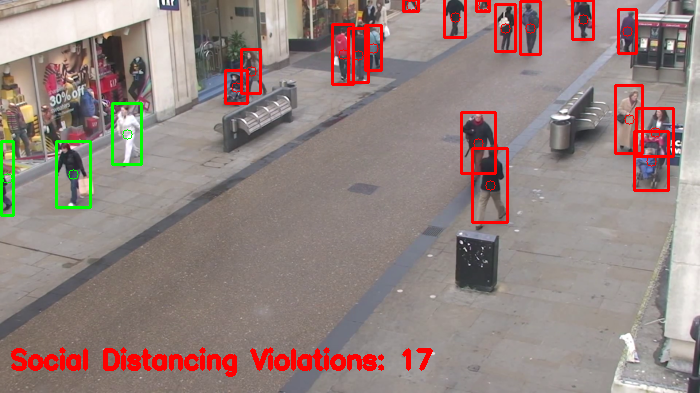

In [ ]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream and pointer to output video file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

# loop over the frames from the video stream
while True:
# while vs.isOpened():
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# resize the frame and then detect people (and only people) in it
	frame = imutils.resize(frame, width=700)
	results = detect_people(frame, net, ln,
		personIdx=LABELS.index("person"))

	# initialize the set of indexes that violate the minimum social
	# distance
	violate = set()

	# ensure there are *at least* two people detections (required in
	# order to compute our pairwise distance maps)
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = np.array([r[2] for r in results])
		D = dist.cdist(centroids, centroids, metric="euclidean")

		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violate.add(i)
					violate.add(j)

	# loop over the results
	for (i, (prob, bbox, centroid)) in enumerate(results):
		# extract the bounding box and centroid coordinates, then
		# initialize the color of the annotation
		(startX, startY, endX, endY) = bbox
		(cX, cY) = centroid
		color = (0, 255, 0)

		# if the index pair exists within the violation set, then
		# update the color
		if i in violate:
			color = (0, 0, 255)

		# draw (1) a bounding box around the person and (2) the
		# centroid coordinates of the person,
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		cv2.circle(frame, (cX, cY), 5, color, 1)

	# draw the total number of social distancing violations on the
	# output frame
	text = "Social Distancing Violations: {}".format(len(violate))
	cv2.putText(frame, text, (10, frame.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

	# check to see if the output frame should be displayed to our
	# screen
	if args["display"] > 0:
		# show the output frame
		# cv2_imshow(frame)
        
		clear_output(wait=True)
		img = arrayShow(frame)
		display(img)

		# key = cv2.waitKey(1) & 0xFF

		# # if the `q` key was pressed, break from the loop
		# if key == ord("q"):
		# 	break

	# if an output video file path has been supplied and the video
	# writer has not been initialized, do so now
	if args["output"] != "" and writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

	# if the video writer is not None, write the frame to the output
	# video file
	if writer is not None:
		writer.write(frame)